<a href="https://colab.research.google.com/github/IronABC/Pairing_Similar_Questions/blob/main/Quora_Question_Pairing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from google.colab import drive
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
import nltk
import pickle
import warnings
warnings.filterwarnings('ignore')
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
data_frame = pd.read_csv('/content/drive/My Drive/data_set/train.csv')
print("Data frame shape : ", data_frame.shape)
data_frame.head()

Data frame shape :  (404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
data_frame[data_frame.isnull().any(axis=1)].count()

id              3
qid1            3
qid2            3
question1       2
question2       1
is_duplicate    3
dtype: int64

In [4]:
data_frame.dropna(axis=0, how='any', inplace=True)
data_frame.shape

(404287, 6)

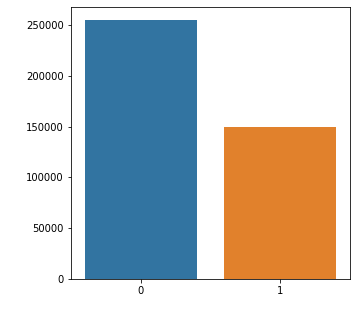

In [5]:
is_dup = data_frame['is_duplicate'].value_counts()
plt.figure(figsize=(5,5))
sns.barplot(is_dup.index, is_dup.values)
plt.xlabel("Is Duplicate", fontsize=15, color='w')
plt.ylabel('Counts', fontsize=15, color='w')
plt.show()

Text(0.5, 0, 'No of words in question')

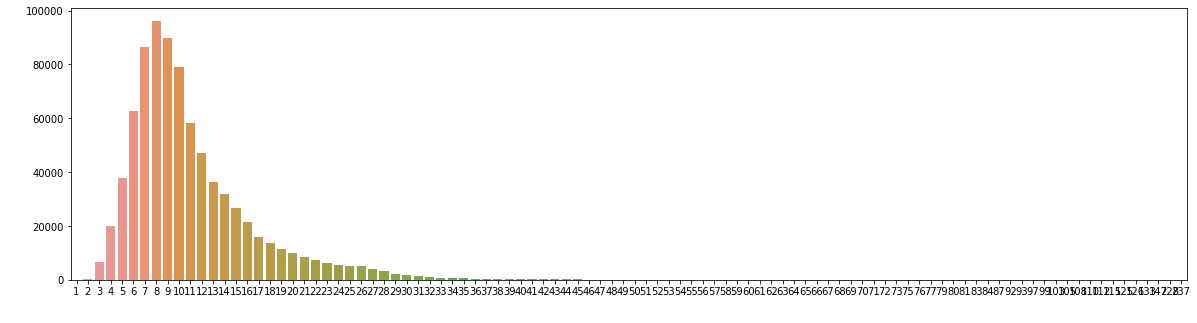

In [6]:
train_qs = pd.Series(data_frame['question1'].tolist()+data_frame['question2'].tolist()).astype(str)
all_ques = train_qs.apply(lambda x: len(str(x).split()))
cnt = all_ques.value_counts()
plt.figure(figsize=(20, 5))
sns.barplot(cnt.index, cnt.values)
plt.ylabel('No of questions', fontsize=15, color='w')
plt.xlabel('No of words in question', fontsize=15, color='w')

Text(0.5, 0, 'No of characters in question')

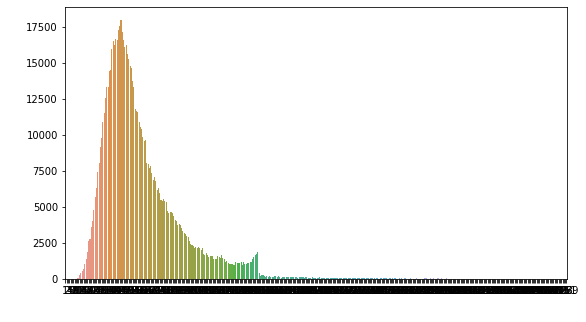

In [7]:
char_len = train_qs.apply(lambda x: len(str(x)))
cnt = char_len.value_counts()
plt.figure(figsize=(9, 5))
sns.barplot(cnt.index, cnt.values)
plt.ylabel('No of questions', fontsize=15, color='w')
plt.xlabel('No of characters in question', fontsize=15, color='w')

In [8]:
word = " ".join(train_qs).lower().split()
counts = Counter(word)
print("length of word = {} \nFirst word = {}".format(len(word), word[0]))

length of word = 8944556 
First word = what


In [9]:
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
#now setting up weight for each word
def get_weight(count, epsilon=10000, min_count=2):
  return 0 if count<min_count else 1/(count+epsilon)
weights = {word:get_weight(count) for word, count in counts.items()}

In [11]:
def word_shares(row):
  q1_list = str(row[3]).lower().split()
  q1 = set(q1_list)
  q1words = q1.difference(stop_words)
  if len(q1words) == 0:
      return '0:0:0:0:0:0:0:0'
  
  q2_list = str(row[4]).lower().split()
  q2 = set(q2_list)
  q2words = q2.difference(stop_words)
  if len(q2words) == 0:
      return '0:0:0:0:0:0:0:0'
  words_hamming = sum(1 for i in zip(q1_list, q2_list) if i[0]==i[1])/max(len(q1_list), len(q2_list))
  q1stops = q1.intersection(stop_words)
  q2stops = q2.intersection(stop_words)
  q1_2gram = set([i for i in zip(q1_list, q1_list[1:])])
  q2_2gram = set([i for i in zip(q2_list, q2_list[1:])])
  shared_2gram = q1_2gram.intersection(q2_2gram)
  shared_words = q1words.intersection(q2words)
  shared_weights = [weights.get(w, 0) for w in shared_words]
  q1_weights = [weights.get(w, 0) for w in q1words]
  q2_weights = [weights.get(w, 0) for w in q2words]
  total_weights = q1_weights + q1_weights
  
  R1 = np.sum(shared_weights) / np.sum(total_weights) #tfidf share
  R2 = len(shared_words) / (len(q1words) + len(q2words) - len(shared_words)) #count share
  R31 = len(q1stops) / len(q1words) #stops in q1
  R32 = len(q2stops) / len(q2words) #stops in q2
  Rcosine_denominator = (np.sqrt(np.dot(q1_weights,q1_weights))*np.sqrt(np.dot(q2_weights,q2_weights)))
  Rcosine = np.dot(shared_weights, shared_weights)/Rcosine_denominator
  if len(q1_2gram) + len(q2_2gram) == 0:
      R2gram = 0
  else:
      R2gram = len(shared_2gram) / (len(q1_2gram) + len(q2_2gram))
  return '{}:{}:{}:{}:{}:{}:{}:{}'.format(R1, R2, len(shared_words), R31, R32, R2gram, Rcosine, words_hamming)

data_frame['word_shares'] = data_frame.apply(word_shares, axis=1, raw=True)

In [12]:
x = pd.DataFrame()
x['word_match']       = data_frame['word_shares'].apply(lambda x: float(x.split(':')[0]))
x['word_match_2root'] = np.sqrt(x['word_match'])
x['tfidf_word_match'] = data_frame['word_shares'].apply(lambda x: float(x.split(':')[1]))
x['shared_count']     = data_frame['word_shares'].apply(lambda x: float(x.split(':')[2]))
x['stops1_ratio']     = data_frame['word_shares'].apply(lambda x: float(x.split(':')[3]))
x['stops2_ratio']     = data_frame['word_shares'].apply(lambda x: float(x.split(':')[4]))
x['shared_2gram']     = data_frame['word_shares'].apply(lambda x: float(x.split(':')[5]))
x['cosine']           = data_frame['word_shares'].apply(lambda x: float(x.split(':')[6]))
x['words_hamming']    = data_frame['word_shares'].apply(lambda x: float(x.split(':')[7]))
x['diff_stops_r']     = x['stops1_ratio'] - x['stops2_ratio']
x['len_q1']           = data_frame['question1'].apply(lambda x: len(str(x)))
x['len_q2']           = data_frame['question2'].apply(lambda x: len(str(x)))
x['diff_len']         = x['len_q1'] - x['len_q2']

x['caps_count_q1']    = data_frame['question1'].apply(lambda x:sum(1 for i in str(x) if i.isupper()))
x['caps_count_q2']    = data_frame['question2'].apply(lambda x:sum(1 for i in str(x) if i.isupper()))
x['diff_caps']        = x['caps_count_q1'] - x['caps_count_q2']
x['len_char_q1']      = data_frame['question1'].apply(lambda x: len(str(x).replace(' ', '')))
x['len_char_q2']      = data_frame['question2'].apply(lambda x: len(str(x).replace(' ', '')))
x['diff_len_char']    = x['len_char_q1'] - x['len_char_q2']
x['len_word_q1']      = data_frame['question1'].apply(lambda x: len(str(x).split()))
x['len_word_q2']      = data_frame['question2'].apply(lambda x: len(str(x).split()))
x['diff_len_word']    = x['len_word_q1'] - x['len_word_q2']
x['avg_world_len1']   = x['len_char_q1'] / x['len_word_q1']
x['avg_world_len2']   = x['len_char_q2'] / x['len_word_q2']
x['diff_avg_word']    = x['avg_world_len1'] - x['avg_world_len2']
x['exactly_same']     = (data_frame['question1'] == data_frame['question2']).astype(int)
x['duplicated']       = data_frame.duplicated(['question1','question2']).astype(int)

def add_word_count(x, df, word):
    x['q1_' + word] = df['question1'].apply(lambda x: (word in str(x).lower())*1)
    x['q2_' + word] = df['question2'].apply(lambda x: (word in str(x).lower())*1)
    x[word + '_both'] = x['q1_' + word] * x['q2_' + word]

add_word_count(x, data_frame,'how')
add_word_count(x, data_frame,'what')
add_word_count(x, data_frame,'which')
add_word_count(x, data_frame,'who')
add_word_count(x, data_frame,'where')
add_word_count(x, data_frame,'when')
add_word_count(x, data_frame,'why')

In [13]:
x.columns

Index(['word_match', 'word_match_2root', 'tfidf_word_match', 'shared_count',
       'stops1_ratio', 'stops2_ratio', 'shared_2gram', 'cosine',
       'words_hamming', 'diff_stops_r', 'len_q1', 'len_q2', 'diff_len',
       'caps_count_q1', 'caps_count_q2', 'diff_caps', 'len_char_q1',
       'len_char_q2', 'diff_len_char', 'len_word_q1', 'len_word_q2',
       'diff_len_word', 'avg_world_len1', 'avg_world_len2', 'diff_avg_word',
       'exactly_same', 'duplicated', 'q1_how', 'q2_how', 'how_both', 'q1_what',
       'q2_what', 'what_both', 'q1_which', 'q2_which', 'which_both', 'q1_who',
       'q2_who', 'who_both', 'q1_where', 'q2_where', 'where_both', 'q1_when',
       'q2_when', 'when_both', 'q1_why', 'q2_why', 'why_both'],
      dtype='object')

In [14]:
x.fillna(0)
x.shape

(404287, 48)

In [15]:
x.head(10)

,word_match,word_match_2root,tfidf_word_match,shared_count,stops1_ratio,stops2_ratio,shared_2gram,cosine,words_hamming,diff_stops_r,len_q1,len_q2,diff_len,caps_count_q1,caps_count_q2,diff_caps,len_char_q1,len_char_q2,diff_len_char,len_word_q1,len_word_q2,diff_len_word,avg_world_len1,avg_world_len2,diff_avg_word,exactly_same,duplicated,q1_how,q2_how,how_both,q1_what,q2_what,what_both,q1_which,q2_which,which_both,q1_who,q2_who,who_both,q1_where,q2_where,where_both,q1_when,q2_when,when_both,q1_why,q2_why,why_both
0,0.372560,0.610377,0.571429,4.0,1.000000,1.200000,0.416667,0.795192,0.785714,-0.200000,66,57,9,1,1,0,53,46,7,14,12,2,3.785714,3.833333,-0.047619,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.256523,0.506481,0.181818,2.0,1.000000,0.333333,0.052632,0.410927,0.076923,0.666667,51,88,-37,5,5,0,44,76,-32,8,13,-5,5.500000,5.846154,-0.346154,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.171507,0.414134,0.222222,2.0,1.333333,1.000000,0.045455,0.340883,0.142857,0.333333,73,59,14,5,5,0,60,50,10,14,10,4,4.285714,5.000000,-0.714286,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.000000,0.000000,0.0,1.500000,0.800000,0.000000,0.000000,0.000000,0.700000,50,65,-15,4,1,3,40,57,-17,11,9,2,3.636364,6.333333,-2.696970,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,0.000000,0.000000,0.000000,0.0,0.300000,0.400000,0.000000,0.000000,0.076923,-0.100000,76,39,37,1,1,0,64,33,31,13,7,6,4.923077,4.714286,0.208791,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0.269175,0.518820,0.307692,4.0,0.875000,0.777778,0.100000,0.488688,0.250000,0.097222,86,90,-4,5,6,-1,71,75,-4,16,16,0,4.437500,4.687500,-0.250000,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0.000000,0.000000,0.000000,0.0,1.000000,0.428571,0.000000,0.000000,0.000000,0.571429,19,62,-43,2,1,1,16,52,-36,4,11,-7,4.000000,4.727273,-0.727273,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0.385400,0.620806,0.333333,1.0,2.500000,3.500000,0.071429,0.748695,0.111111,-1.000000,30,41,-11,2,2,0,24,33,-9,7,9,-2,3.428571,3.666667,-0.238095,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0.198258,0.445262,0.333333,2.0,1.000000,1.000000,0.285714,0.318783,0.750000,0.000000,31,37,-6,1,1,0,24,30,-6,8,8,0,3.000000,3.750000,-0.750000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0
9,0.239904,0.489800,0.222222,2.0,0.500000,0.800000,0.062500,0.506342,0.000000,-0.300000,60,49,11,8,6,2,52,41,11,9,9,0,5.777778,4.555556,1.222222,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Feature Engineering**

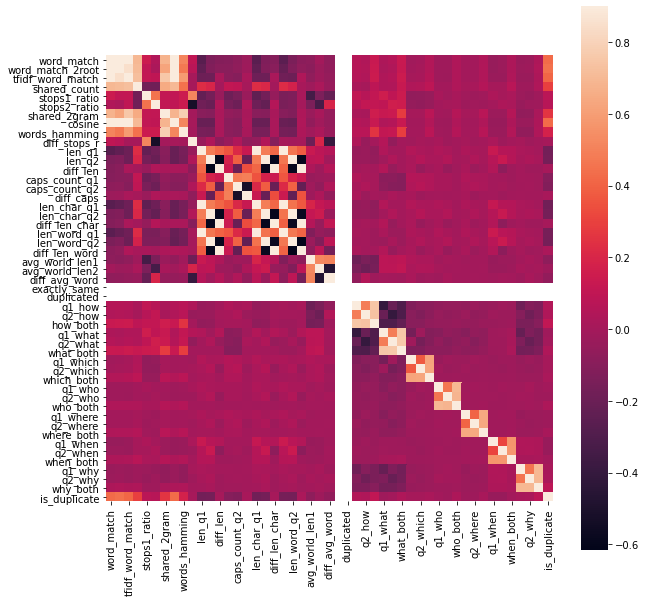

In [16]:
x['is_duplicate'] = data_frame['is_duplicate']
plt.subplots(figsize=(10,10))
sns.heatmap(x.corr(), vmax=0.9, square=True)

In [17]:
y = x.is_duplicate
x.drop(labels=['is_duplicate'], inplace=True, axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(404287, 48)
(323429, 48)
(323429,)
(80858, 48)
(80858,)


In [18]:
param = {'learning_rate': 0.1, 
         'boosting_type': 'dart', 
         'objective': 'binary', 
         'metric': 'binary_logloss', 
         'sub_feature': 0.5, 
         'num_leaves': 512, 
         'min_data': 50, 
         'min_hessian': 1}

def train_lgb(X_train, y_train, X_test, y_test, param):
  xg_train = lgb.Dataset(X_train, label=y_train)
  xg_val = lgb.Dataset(X_test, label=y_test)
  watchlist  = [xg_val]
  ROUNDS = 190
  print("Training started\n\n")
  clf = lgb.train(param, xg_train, ROUNDS, watchlist)
  print("\n\nTraining completed\n")
  return clf

def pred_lgb(clf, X_test):
  return clf.predict(X_test)

lgb_model = train_lgb(X_train, y_train, X_test, y_test, param)

Training started


[1]	valid_0's binary_logloss: 0.627492
[2]	valid_0's binary_logloss: 0.598238
[3]	valid_0's binary_logloss: 0.577729
[4]	valid_0's binary_logloss: 0.557743
[5]	valid_0's binary_logloss: 0.540521
[6]	valid_0's binary_logloss: 0.524538
[7]	valid_0's binary_logloss: 0.513252
[8]	valid_0's binary_logloss: 0.519194
[9]	valid_0's binary_logloss: 0.505705
[10]	valid_0's binary_logloss: 0.495683
[11]	valid_0's binary_logloss: 0.485596
[12]	valid_0's binary_logloss: 0.489038
[13]	valid_0's binary_logloss: 0.481305
[14]	valid_0's binary_logloss: 0.473067
[15]	valid_0's binary_logloss: 0.465583
[16]	valid_0's binary_logloss: 0.459004
[17]	valid_0's binary_logloss: 0.454431
[18]	valid_0's binary_logloss: 0.44973
[19]	valid_0's binary_logloss: 0.445027
[20]	valid_0's binary_logloss: 0.441879
[21]	valid_0's binary_logloss: 0.442783
[22]	valid_0's binary_logloss: 0.43983
[23]	valid_0's binary_logloss: 0.436222
[24]	valid_0's binary_logloss: 0.432919
[25]	valid_0's binary_logloss: 0

In [19]:
y_pred = lgb_model.predict(X_test)
log_loss(y_test, y_pred)

0.3964399575893999

In [20]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic', 'nthread': 4, 'eval_metric': 'logloss'}
def train_xgb(X_train, y_train, X_text, y_test, param):
  xgb_train = xgb.DMatrix(X_train, label=y_train)
  xgb_test = xgb.DMatrix(X_test, label=y_test)
  evallist = [(xgb_test, 'eval'), (xgb_train, 'train')]
  print("Traing started\n\n")
  clf = xgb.train(param, xgb_train, 200, evallist)
  print("\n\nTraing completed\n")
  return clf

xgb_model = train_xgb(X_train, y_train, X_test, y_test, param)

Traing started


[0]	eval-logloss:0.499383	train-logloss:0.498829
[1]	eval-logloss:0.471775	train-logloss:0.471092
[2]	eval-logloss:0.462815	train-logloss:0.462323
[3]	eval-logloss:0.459376	train-logloss:0.458674
[4]	eval-logloss:0.455296	train-logloss:0.4551
[5]	eval-logloss:0.453226	train-logloss:0.452853
[6]	eval-logloss:0.451134	train-logloss:0.450572
[7]	eval-logloss:0.449809	train-logloss:0.449106
[8]	eval-logloss:0.448417	train-logloss:0.447618
[9]	eval-logloss:0.446529	train-logloss:0.445989
[10]	eval-logloss:0.445688	train-logloss:0.444867
[11]	eval-logloss:0.445292	train-logloss:0.444219
[12]	eval-logloss:0.444739	train-logloss:0.443624
[13]	eval-logloss:0.443959	train-logloss:0.442829
[14]	eval-logloss:0.443513	train-logloss:0.442178
[15]	eval-logloss:0.443341	train-logloss:0.441736
[16]	eval-logloss:0.442644	train-logloss:0.441182
[17]	eval-logloss:0.442216	train-logloss:0.440834
[18]	eval-logloss:0.441496	train-logloss:0.440176
[19]	eval-logloss:0.441006	train-logloss:0.43

In [21]:
def logLoss(model, X_test, y_test):
  temp = xgb.DMatrix(X_test, label=y_test)
  y_pred = xgb_model.predict(temp)
  print(log_loss(y_test, y_pred))

logLoss(xgb_model, X_train, y_train)

0.4144065469669878


In [22]:
def train_rfc(X_train, y_train, X_test, y_test):
  rfc = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=100, min_weight_fraction_leaf=0.0, 
                             max_features='sqrt', max_leaf_nodes=None, bootstrap=True, oob_score=True, n_jobs=1, random_state=1, verbose=0, warm_start=False, 
                             class_weight=None)
  print("Training started")
  rfc.fit(X_train.fillna(0), y_train.fillna(0))
  print("Training completed")
  return rfc

rfc_model = train_rfc(X_train, y_train, X_test, y_test)

Training started
Training completed


In [23]:
y_pred = rfc_model.predict_proba(X_test.fillna(0))
print("logloss : ", log_loss(y_test, y_pred))

logloss :  0.4252090864706484


In [24]:
pickle.dump(lgb_model, open('model.pkl', 'wb'))
mdl = pickle.load(open('model.pkl', 'rb'))

In [41]:
import nltk
import numpy as np
from collections import Counter

stop_words = set(nltk.corpus.stopwords.words('english'))

def get_weight(count, epsilon=10000, min_count=2):
  return 0 if count<min_count else 1/(count+epsilon)


def feature_create(ques1, ques2):
    word = (ques1 + " " + ques2).lower().split()
    count = Counter(word)

    weights = {word:get_weight(count) for word, count in count.items()}
    q1_list = str(ques1).lower().split()
    q2_list = str(ques2).lower().split()

    q1 = set(q1_list)
    q2 = set(q2_list)

    q1_words = q1.difference(stop_words)
    q2_words = q2.difference(stop_words)

    q1_stop = q1.intersection(stop_words)
    q2_stop = q2.intersection(stop_words)

    q1_bigram = set([i for i in zip(q1_list, q1_list[1:])])
    q2_bigram = set([i for i in zip(q2_list, q2_list[1:])])

    common_bigram = q1_bigram.intersection(q2_bigram)
    #common_words = q1.intersection(q2)

    q1_weights = [weights.get(wrd, 0) for wrd in q1_words]
    q2_weights = [weights.get(wrd, 0) for wrd in q2_words]

    shared_words = q1_words.intersection(q2_words)
    shared_weights = [weights.get(w, 0) for w in shared_words]

    #common_weight = [weights.get(wrd, 0) for wrd in common_words]
    total_weights = q1_weights = q2_weights
    rcosine_denominator = (np.sqrt(np.dot(q1_weights,q1_weights)) * np.sqrt(np.dot(q2_weights,q2_weights)))
    word_hamming = sum(1 for i in zip(q1_list, q2_list) if i[0]==i[1] )/max(len(q1_list), len(q2_list))

    R1 = np.sum(shared_weights) / np.sum(total_weights) #tfidf share
    R2 = len(shared_words) / (len(q1_words) + len(q2_words) - len(shared_words)) #count share
    R31 = len(q1_stop) / len(q1_words) #stops in q1
    R32 = len(q2_stop) / len(q2_words) #stops in q2
    rcosine = np.dot(shared_weights, shared_weights)/rcosine_denominator

    if len(q1_bigram) + len(q2_bigram) == 0:
      r2gram = 0
    else:
      r2gram = len(common_bigram) / (len(q1_bigram) + len(q2_bigram))
          
    x = dict()
    x['word_match']       = R1
    x['word_match_2root'] = np.sqrt(x['word_match'])
    x['tfidf_word_match'] = R2
    x['shared_count']     = len(shared_words)
    x['stops1_ratio']     = R31
    x['stops2_ratio']     = R32
    x['shared_2gram']     = r2gram
    x['cosine']           = rcosine
    x['words_hamming']    = word_hamming
    x['diff_stops_r']     = x['stops1_ratio'] - x['stops2_ratio']
    x['len_q1']           = len(str(ques1))
    x['len_q2']           = len(str(ques2))
    x['diff_len']         = x['len_q1'] - x['len_q2']
    x['caps_count_q1']    = sum(1 for i in str(ques1) if i.isupper())
    x['caps_count_q2']    = sum(1 for i in str(ques2) if i.isupper())
    x['diff_caps']        = x['caps_count_q1'] - x['caps_count_q2']
    x['len_char_q1']      = len(str(x).replace(' ', ''))
    x['len_char_q2']      = len(str(x).replace(' ', ''))
    x['diff_len_char']    = x['len_char_q1'] - x['len_char_q2']
    x['len_word_q1']      = len(str(x).split())
    x['len_word_q2']      = len(str(x).split())
    x['diff_len_word']    = x['len_word_q1'] - x['len_word_q2']
    x['avg_world_len1']   = x['len_char_q1'] / x['len_word_q1']
    x['avg_world_len2']   = x['len_char_q2'] / x['len_word_q2']
    x['diff_avg_word']    = x['avg_world_len1'] - x['avg_world_len2']
    x['exactly_same']     = (ques1 == ques2)#.astype(int)
    x['duplicated']       = (ques1 == ques2)#.astype(int)

    def add_word_count(x, word):
        x['q1_' + word] = (word in str(ques1).lower())*1
        x['q2_' + word] = (word in str(ques2).lower())*1
        x[word + '_both'] = x['q1_' + word] * x['q2_' + word]

    add_word_count(x, 'how')
    add_word_count(x, 'what')
    add_word_count(x, 'which')
    add_word_count(x, 'who')
    add_word_count(x, 'where')
    add_word_count(x, 'when')
    add_word_count(x, 'why')
    arr = np.array([[x[i] for i in x]])
    return arr

In [42]:
# quest1 = input("quest1 : ")
# quest2 = input('quest2 : ')

ques11 = "How do you identify binary classification problem?"
quest2 = "What is binary classification?"
sample = feature_create(quest1, quest2)
p = mdl.predict(sample)
if p > 0.5 :
  print('Similar question')
else:
  print('Not similar question')

Not similar question
